#### Iniciando a SparkSession

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("EDA - Rossmann (processing)").getOrCreate()

#### Criando os DataFrames

In [4]:
train_path = "../data/raw/rossmann_store_sales/train.csv"
store_path = "../data/raw/rossmann_store_sales/store.csv"

train_df = spark.read.option("header", True).option("inferSchema", True).csv(train_path)
store_df = spark.read.option("header", True).option("inferSchema", True).csv(store_path)

#### Exibição da quantidade e percentual de valores nulos por coluna

In [5]:
from pyspark.sql.functions import when, count, isnan, col, lit, round

def missing_values_summary(df):
    total_rows = df.count()
    summary_df = df.select([
        count(when(col(c).isNull() | (isnan(col(c)) if dtype in ["double", "float"] else lit(False)), c)).alias(c)
        for c, dtype in df.dtypes
    ])

    summary = summary_df.toPandas().T.reset_index()
    summary.columns = ["column", "missing_count"]
    summary["missing_percent"] = ((summary["missing_count"]/total_rows) * 100).round(2)

    return summary.sort_values(by="missing_percent", ascending=False)

In [6]:
missing_summary_store = missing_values_summary(store_df)
print("Missing values from train:")
print(missing_summary_store)

Missing values from train:
                      column  missing_count  missing_percent
9              PromoInterval            544            48.79
8            Promo2SinceYear            544            48.79
7            Promo2SinceWeek            544            48.79
5   CompetitionOpenSinceYear            354            31.75
4  CompetitionOpenSinceMonth            354            31.75
3        CompetitionDistance              3             0.27
1                  StoreType              0             0.00
0                      Store              0             0.00
2                 Assortment              0             0.00
6                     Promo2              0             0.00


/tmp/ipykernel_97537/2966631930.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


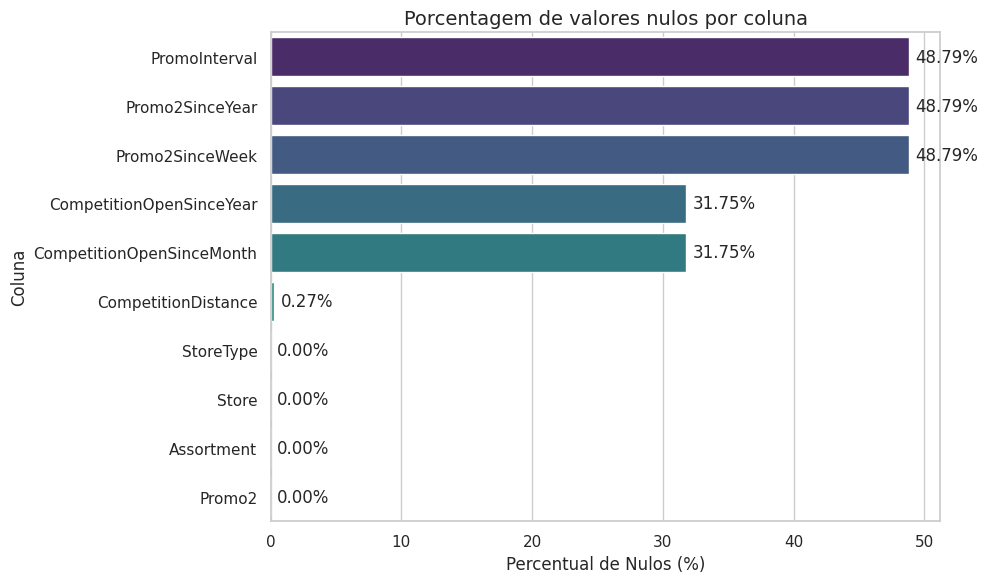

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define o tamanho e estilo do gráfico
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.barplot(
    data=missing_summary_store,
    x="missing_percent",
    y="column",
    palette="viridis"
)

# Títulos e rótulos
plt.title("Porcentagem de valores nulos por coluna", fontsize=14)
plt.xlabel("Percentual de Nulos (%)")
plt.ylabel("Coluna")

# Mostrar valores no topo das barras
for index, value in enumerate(missing_summary_store["missing_percent"]):
    plt.text(value + 0.5, index, f"{value:.2f}%", va='center')

plt.tight_layout()
plt.show()

##### Entendendo contexto
A coluna DistanceCompetition representa a distância da loja concorrente mais próxima em metros. Ela tem apenas 3 valores nulos, o que é apenas 0.27% do total, uma quantidade bem pequena

##### Decisão
Como a concorrência é uma variável importante e esses valores são poucos, abordagem mais comum (e segura) é preencher os nulos com média ou mediana. Eu decidi usar a mediana por ser mais robusta contra outliers.

In [8]:
from pyspark.sql.functions import expr

# Verificando a média
median_distance = store_df.approxQuantile("CompetitionDistance", [0.5], 0.01)[0]

# Preenchendo os nulos com mediana
store_df = store_df.fillna({"CompetitionDistance": median_distance})